In [1]:
%matplotlib inline
import numpy as np
from gPhoton.pipeline import execute_pipeline
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from gPhoton.io.fits_utils import get_fits_data, read_wcs_from_fits
from astropy.visualization import ZScaleInterval
import os
import tqdm
import imageio.v2 as imageio
from IPython.display import Image
import astropy.wcs
from gPhoton.coadd import make_shared_wcs, project_to_shared_wcs, bin_projected_weights

Pipeline steps:
1. Run photometry with extraction on NUV
2. Run photometry with extraction on FUV
3. Run photometry on FUV with NUV source positions
4. Run photometry on NUV with FUV source positions
5. Generate a merged catalog from NUV extractions
6. Generate a merged catalog from FUV extractions
7. Generate a merged catalog from all NUV / FUV detections

In [2]:
from glcat_merge_utils import *
from lightcurve_utils import *

In [3]:
eclipse = 23456
datadir = "/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/"
edir = f"e{str(eclipse).zfill(5)}"
nn = pd.read_csv(f"{datadir}{edir}/{edir}-nd-b00-f0120-movie-photom-12_8-mon.csv",index_col=None)
ff = pd.read_csv(f"{datadir}{edir}/{edir}-fd-b00-f0120-movie-photom-12_8-mof.csv",index_col=None)
nf = pd.read_csv(f"{datadir}{edir}/{edir}-nd-b00-f0120-movie-photom-12_8-mof.csv",index_col=None)
fn = pd.read_csv(f"{datadir}{edir}/{edir}-fd-b00-f0120-movie-photom-12_8-mon.csv",index_col=None)

nexpt = pd.read_csv(f"{datadir}{edir}/{edir}-nd-b00-f0120-movie-exptime.csv",index_col=None)
fexpt = pd.read_csv(f"{datadir}{edir}/{edir}-fd-b00-f0120-movie-exptime.csv",index_col=None)

In [4]:
def crossmatch_catalogs(master_table, match_table, match_radius=3*4.17e-4):
    match_catalog = SkyCoord(ra=match_table['ra'].values*u.degree,
                             dec=match_table['dec'].values*u.degree)
    master_catalog = SkyCoord(ra=master_table['ra'].values*u.degree,
                              dec=master_table['dec'].values*u.degree)
    catalog_ix, d2d, d3d = match_catalog.match_to_catalog_sky(master_catalog)
    mask = np.ones(np.array(d2d).shape)
    mask[np.where(np.array(d2d)>match_radius)] = 0
    d2d_masked = np.ma.array(d2d,mask=mask)
    catalog_ix_masked = np.ma.array(catalog_ix,mask=mask)
    return d2d_masked, catalog_ix_masked

In [5]:
d2d_masked, catalog_ix_masked = crossmatch_catalogs(nn,ff,match_radius=3*4.17e-4)

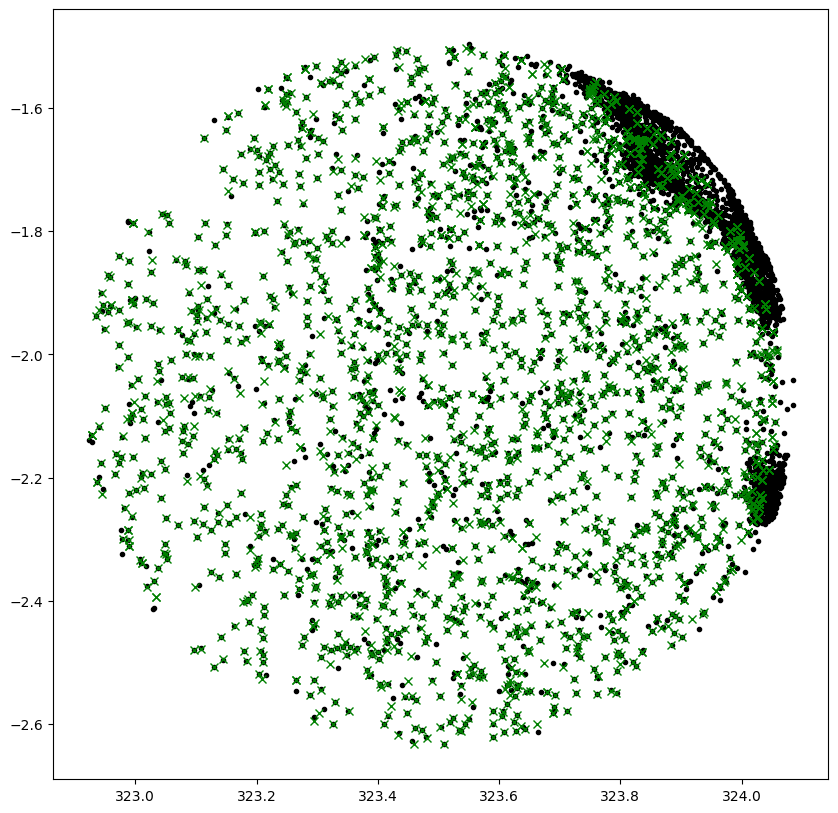

In [8]:
plt.figure(figsize=(10,10))
plt.plot(ff['ra'],ff['dec'],'k.')
plt.plot(nn['ra'].iloc[catalog_ix_masked],
         nn['dec'].iloc[catalog_ix_masked],
         'gx')

In [16]:
primary_catalog_columns = [
    #'ra','dec',
    #'xcentroid','ycentroid',
    'xcenter','ycenter',
    #'elongation','eccentricity',
    #'max_value','maxval_xindex','maxval_yindex',
    #'min_value','minval_xindex','minval_yindex',
    'extended_source',
    'aperture_sum',
    #'aperture_sum_mask','aperture_sum_edge',
]

matched_catalog_columns = [
    #'ra','dec',
    #'xcentroid','ycentroid',
    'xcenter','ycenter',
    'aperture_sum',
    #'aperture_sum_mask','aperture_sum_edge',
]

In [20]:
def derived_photometry_table(catalog_table,exposure_table,band):
    assert band in ['NUV','FUV']
    expt = exposure_table.expt.sum()
    cps = np.array(catalog_table.aperture_sum.tolist())/expt
    cps_err = np.sqrt(catalog_table.aperture_sum.tolist())/expt
    mag = counts2mag(cps,band)
    mag_err = np.abs(counts2mag(cps-cps_err,band) - mag)
    return pd.DataFrame(
        {'cps':cps,'cps_err':cps_err,
         'mag':mag,'mag_err':mag_err,
         'expt':expt,
         'mask_flag':(catalog_table['aperture_sum_mask'] != 0).astype(int),
         'edge_flag':(catalog_table['aperture_sum_edge'] != 0).astype(int),}
    )
    aperture_sum_mask

In [40]:
# generate merged NUV catalog
primary = pd.concat([nn[primary_catalog_columns],
                     derived_photometry_table(nn,nexpt,'NUV')],
                    axis=1)

matched = pd.concat([fn[matched_catalog_columns],
                     derived_photometry_table(fn,fexpt,'FUV')],
                    axis=1)

nuv_cat = pd.concat(
    [nn[['ra','dec']], # identical in both bands
     pd.DataFrame({'eclipse':np.full(len(nn),eclipse)}),
     primary.add_suffix('_nuv'),
     matched.add_suffix('_fuv'),],
    axis=1)

In [39]:
# generate merged FUV catalog
primary = pd.concat([ff[primary_catalog_columns],
                     derived_photometry_table(ff,nexpt,'NUV')],
                    axis=1)

matched = pd.concat([nf[matched_catalog_columns],
                     derived_photometry_table(nf,fexpt,'FUV')],
                    axis=1)

fuv_cat = pd.concat(
    [ff[['ra','dec']], # identical in both bands
     pd.DataFrame({'eclipse':np.full(len(ff),eclipse)}),
     primary.add_suffix('_fuv'),
     matched.add_suffix('_nuv'),],
    axis=1)

fuv_cat

,ra,dec,eclipse,xcenter_fuv,ycenter_fuv,extended_source_fuv,aperture_sum_fuv,cps_fuv,cps_err_fuv,mag_fuv,...,xcenter_nuv,ycenter_nuv,aperture_sum_nuv,cps_nuv,cps_err_nuv,mag_nuv,mag_err_nuv,expt_nuv,mask_flag_nuv,edge_flag_nuv
0,323.509837,-2.632055,23456,1460.456727,196.750320,0,243.482699,0.162297,0.010401,22.054223,...,1492.139379,186.550293,1436.925200,0.856233,0.022588,18.988520,0.029027,1678.19451,0,0
1,323.456429,-2.626741,23456,1588.506153,209.505800,0,143.503114,0.095654,0.007985,22.628240,...,1620.189129,199.304178,1086.444367,0.647389,0.019641,19.292087,0.033450,1678.19451,0,0
2,323.480038,-2.621575,23456,1531.901204,221.905105,0,237.947972,0.158608,0.010282,22.079189,...,1563.584209,211.704241,1582.707095,0.943101,0.023706,18.883604,0.027640,1678.19451,0,0
3,323.589603,-2.621367,23456,1269.209061,222.391674,0,149.919402,0.099931,0.008162,22.580749,...,1300.891808,212.194151,1235.478472,0.736195,0.020945,19.152518,0.031337,1678.19451,0,0
4,323.434578,-2.615019,23456,1640.896670,237.639575,0,955.173198,0.636685,0.020601,20.570188,...,1672.580023,227.437376,52619.308284,31.354714,0.136688,15.079243,0.004744,1678.19451,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3957,323.746538,-1.551791,23456,892.500563,2789.420749,0,180.866118,0.120559,0.008964,22.377001,...,924.210978,2779.225011,1321.136037,0.787237,0.021659,19.079737,0.030290,1678.19451,0,1
3958,323.332308,-1.538430,23456,1886.335470,2821.518723,0,562.242968,0.374772,0.015805,21.145584,...,1918.044286,2811.315437,2459.194902,1.465381,0.029550,18.405123,0.022118,1678.19451,0,0
3959,323.330821,-1.536653,23456,1889.905329,2825.784542,0,560.356100,0.373514,0.015779,21.149233,...,1921.614186,2815.581221,2497.992030,1.488500,0.029782,18.388128,0.021944,1678.19451,0,0
3960,323.604938,-1.515287,23456,1232.225045,2877.069324,0,318.478908,0.212287,0.011896,21.762692,...,1263.935266,2866.870725,2287.419065,1.363024,0.028499,18.483741,0.022942,1678.19451,0,0


Text(0, 0.5, 'FUV MAG')

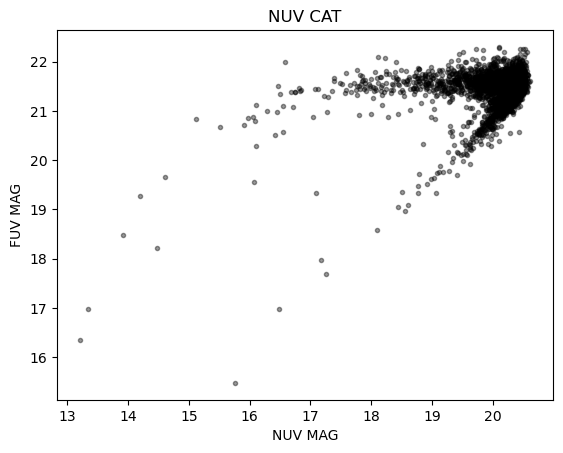

In [47]:
plt.plot(nuv_cat['mag_nuv'],nuv_cat['mag_fuv'],'k.',alpha=0.4)
plt.title('NUV CAT')
plt.xlabel('NUV MAG')
plt.ylabel('FUV MAG')